## Plant Disease Detection using Computer Vision.

In [71]:
# import Necessary libraries for Deep learning and Computer Vision.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
import pandas as pd
import random

In [72]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 32

## Read the files, load the dataset with label such as healthy, rust and powdery.

In [73]:
# As dataset is large, need to load the dataset from Google drive, I uploaded data on my Google drive account.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
# Now load the data and extract the zip folder to local folder on Google colab as it will be used from local extracted folder.

zip_path = '/content/gdrive/MyDrive/plant-Diseaese_dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_images_new_folder')



## Now load the data in train, test and validate images with labels.

In [75]:
images_train = []
labels_train = []

images_test = []
labels_test = []

folder_path = '/content/extracted_images_new_folder/Train/Train'

test_folder = '/content/extracted_images_new_folder/Test/Test'

validation_folder = '/content/extracted_images_new_folder/Validation/Validation'

for dirfolder in os.listdir(folder_path):
    dirfolderpath = os.path.join(folder_path, dirfolder)
    for image_file in os.listdir(dirfolderpath):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
          image_path = os.path.join(dirfolderpath, image_file)
          image = load_img(image_path, target_size=(224, 224))
          image = img_to_array(image)

          image_data = preprocess_input(image)
          images_train.append(image_data)
          labels_train.append(dirfolder)


for dirfolder in os.listdir(test_folder):
    dirfolderpath = os.path.join(test_folder, dirfolder)
    for image_file in os.listdir(dirfolderpath):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
          image_path = os.path.join(dirfolderpath, image_file)
          image = load_img(image_path, target_size=(224, 224))
          image = img_to_array(image)

          image_data = preprocess_input(image)
          images_test.append(image_data)
          labels_test.append(dirfolder)

# merge test and validation into one list as both are very less to test.
for dirfolder in os.listdir(validation_folder):
    dirfolderpath = os.path.join(validation_folder, dirfolder)
    for image_file in os.listdir(dirfolderpath):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
          image_path = os.path.join(dirfolderpath, image_file)
          image = load_img(image_path, target_size=(224, 224))
          image = img_to_array(image)

          image_data = preprocess_input(image)
          images_test.append(image_data)
          labels_test.append(dirfolder)



## Show files that data is loaded correctly using matplotlib library for Train Data.

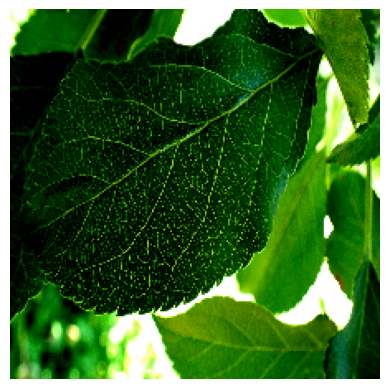

Healthy


In [76]:
plt.imshow(images_train[500][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(labels_train[500])

In [77]:
# Now check that data is loaded correctly for test folder.

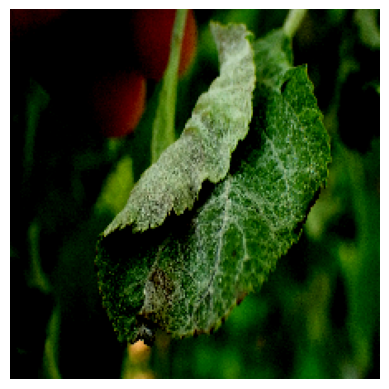

Powdery


In [78]:
plt.imshow(images_test[205][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(labels_test[205])

## Convert into equivalent data.

In [79]:
images_train = np.array(images_train, dtype="float32")
images_test = np.array(images_test, dtype="float32")

lb = LabelEncoder()
labels = lb.fit_transform(labels_train)
labels_train = to_categorical(labels)

labels = lb.fit_transform(labels_test)
labels_test = to_categorical(labels)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

total_categories = len(labels_train[0])

## Random the list so that it can be trained correctly.

In [80]:
# Now it is required to randomize the data.
data = []

data_test = []

for index,l in enumerate(images_train):
    obj = {}
    obj['image'] = images_train[index]
    obj['label'] = labels_train[index]
    data.append(obj)


for index,l in enumerate(images_test):
    obj = {}
    obj['image'] = images_test[index]
    obj['label'] = labels_test[index]
    data_test.append(obj)


# Check for the data object, after random.


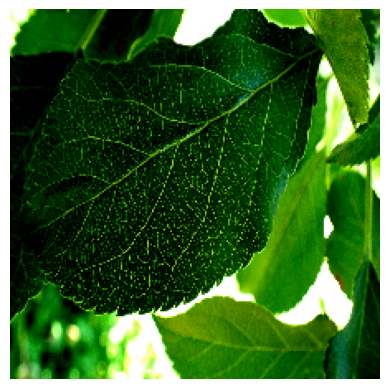

[1. 0. 0.]


In [81]:
plt.imshow(data[500]['image'][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(data[500]['label'])

## Random the data now.

In [82]:
random.shuffle(data)
random.shuffle(data_test)

# verify that randow is done correctly within list.

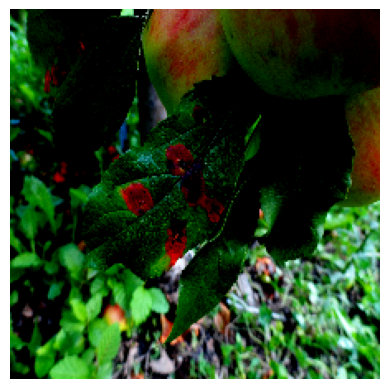

[0. 0. 1.]


In [83]:
plt.imshow(data[30]['image'][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(data[30]['label'])

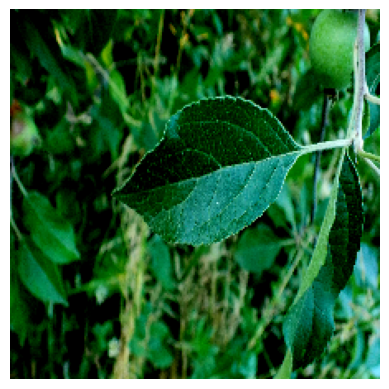

[1. 0. 0.]


In [84]:
plt.imshow(data_test[70]['image'][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(data_test[70]['label'])

In [85]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
	)


baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

head = baseModel.output
head = AveragePooling2D(pool_size=(4, 4))(head)
head = Flatten(name="flatten")(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(total_categories, activation="softmax")(head)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=head)



for layer in baseModel.layers:
	layer.trainable = False

# compile the model.
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()


[INFO] compiling model...
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                 

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 block_4_add (Add)              (None, 28, 28, 32)   0           ['block_3_project_BN[0][0]',     
                                                                  'block_4_project_BN[0][0]']     
                                                                                                  
 block_5_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_4_add[0][0]']            
                                                                                                  
 block_5_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_5_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_5_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_5_expand_BN[0][0]']      
          

In [86]:
print("[INFO] train the model")

selected_property_image = [item['image'] for item in data]

selected_property_label = [item['label'] for item in data]

selected_property_image = np.array(selected_property_image, dtype="float32")

selected_property_label = np.array(selected_property_label)


#print(selected_property_image.shape)

#print(selected_property_label.shape)

model.fit(
	aug.flow(selected_property_image, selected_property_label, batch_size=BS),
	steps_per_epoch=len(selected_property_image) // BS,
	validation_data=(selected_property_image, selected_property_label),
	validation_steps=len(selected_property_label) // BS,
	epochs=EPOCHS)


[INFO] train the model
Epoch 1/50
41/41 [==============================] - 223s 4s/step - loss: 1.7067 - accuracy: 0.3581 - val_loss: 1.0601 - val_accuracy: 0.4773
Epoch 2/50
41/41 [==============================] - 155s 4s/step - loss: 1.3328 - accuracy: 0.3690 - val_loss: 1.0474 - val_accuracy: 0.5620
Epoch 3/50
41/41 [==============================] - 157s 4s/step - loss: 1.2668 - accuracy: 0.3504 - val_loss: 1.0483 - val_accuracy: 0.5802
Epoch 4/50
41/41 [==============================] - 157s 4s/step - loss: 1.1833 - accuracy: 0.3767 - val_loss: 1.0427 - val_accuracy: 0.6051
Epoch 5/50
41/41 [==============================] - 158s 4s/step - loss: 1.1634 - accuracy: 0.3620 - val_loss: 1.0292 - val_accuracy: 0.6747
Epoch 6/50
41/41 [==============================] - 156s 4s/step - loss: 1.1030 - accuracy: 0.4132 - val_loss: 1.0068 - val_accuracy: 0.7474
Epoch 7/50
41/41 [==============================] - 156s 4s/step - loss: 1.1188 - accuracy: 0.3930 - val_loss: 0.9891 - val_accurac

# Predict the model with test data to find the accuracy.

In [91]:
selected_property_image_test = [item['image'] for item in data_test]

selected_property_label_test = [item['label'] for item in data_test]

selected_property_image_test = np.array(selected_property_image_test, dtype="float32")

selected_property_label_test = np.array(selected_property_label_test)

print("evaluation of neural network")
predIdxs = model.predict(selected_property_image_test, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a classification report
print(classification_report(selected_property_label_test.argmax(axis=1), predIdxs,
	target_names=lb.classes_))



evaluation of neural network
7/7 [==============================] - 9s 1s/step
              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.96        70
     Powdery       0.99      0.94      0.96        70
        Rust       0.95      1.00      0.97        70

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



# save the model.

In [90]:
model.save("Plant_Disease_Detection.model", save_format="h5")

## create a pickle file.

In [89]:
# Generate pickle file to use this notebook in application.

import sys
import pickle

projectabspathname = os.path.abspath('Enterprise_Plant_Disease_Detection.pickle')
print(projectabspathname)
projectname = 'Enterprise_Plant_Disease_Detection.ipynb'
projectpickle = open(str(projectabspathname),'wb')
pickle.dump(projectname, projectpickle)
projectpickle.close()

/content/Enterprise_Plant_Disease_Detection.pickle
